<a href="https://colab.research.google.com/github/MAClaassen/python_course/blob/main/2022_IDSP_MVS_II_Wk_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Multivariate Statistics III: Pt 2- ANOVA Post-Hoc, Finding Interactions

## 0.0.0 Action Load Basic Libaries

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import sklearn as skl
import scipy as sci
import scipy.io as sio


#configure the plotting defaluts
plt.rcParams['figure.figsize'] = [15.256 , 6.024]
plt.rcParams['figure.dpi'] = 300 

#### 0.1 Import the statsmodels package

We are using the Stats Models libary as it let's us explictly write the statistical model using the same syntax as R.  

This also allows us to run the Tukey test with minimal lines of code.

**note** OLS stands for ordinary least squares, which is the basic fitting techniqe which most fitting is based off of.

In [2]:
# new libaries for running annova tests

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.2 Connect to the google drive locations

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

data_path='/content/drive/MyDrive/2022_SFC_IDSP/datasets/'


results_path='/content/drive/My Drive/2022_SFC_IDSP/Week_5/'

Mounted at /content/drive/


#### 0.3 Example load and inspect the data preparing for ANOVA

load the '2022_IDSP_wk4_fuel_data.xlsx'.



In [4]:
simple_mpg=pd.read_hdf(data_path+'IDSP_wk4_fuel_econ_filtered.h5')
simple_mpg.dtypes

year                 int64
make              category
model             category
VClass            category
trany             category
drive             category
eng_dscr          category
cylinders          float64
displ              float64
fuelType            object
city08               int64
UCity              float64
highway08            int64
UHighway           float64
co2TailpipeGpm     float64
dtype: object

## 2.0 Introduction to Post-hoc analysis

In the first part of Week 5's lectures we saw howthe ANOVA test demonstrated that the interaction between type of fuel a vechile uses and the drive train design work as statistically significant predectors in describing the average the CO$_2$ emissions of a particular vechicle.

As is expected what we did not understadnd from the ANOVA is which exact interaction means contrbute to this signifficant difference.

For that we agian turn to the Tukey HSD to examine the pair wiase signifficant differnces.



## 2.1 Post-hoc Tukey

As the final part of the ANOVA process now that we can see that the interaction of fueltype and drive train provides a signifficant role in explaining the distribution of emissions data. 

To do this we will again turn to the Tukey HSD test to find the pairings which are statistically differnt from one another.

First, look at the number of combinations of these two catagories; there are 7 types of drive train and 12 types of fuel, and while that would technically result in over 3486 possiable pairs (see code below) of combinations to check we can cut it down pretty quickly by remembering that some of these combinations are null, since not all drive train and fuel type combinations exist.

The total pairs given by thinking of the binomial coefficents, which is a way of saying given n objects how many ways can you combine k ways:

${\binom {n}{k}}={\frac {n!}{k!(n-k)!}}$

for our overall system this would be:

${\binom {84}{2}}={\frac {84!}{2!(84-2)!}}$

which as worked out below calling some python functions as a total possiable combinations of 3486. That is a lot, but do not loose hope as we will see below.

In [5]:
kinds_drive=len(np.unique(simple_mpg['drive']))
kinds_fuel=len(np.unique(simple_mpg['fuelType']))

print('there are {} types of drive train and {} differnt types of fuel classifications'.format(kinds_drive,kinds_fuel))

there are 7 types of drive train and 12 differnt types of fuel classifications


In [6]:
 # this calcualtes the binomical coefficents or the number of pairings possiable.
 sci.special.comb(kinds_drive*kinds_fuel, 2) 

3486.0

#### 2.1.1 Example: code showing what numbers of elements (measurments) for each of the interaction crosses.

keep in mind this still keeps groups of a single member (ie std = 0)

In [7]:
pd.crosstab(simple_mpg['drive'],simple_mpg['fuelType'])

fuelType,CNG,Diesel,Electricity,Gasoline or E85,Gasoline or natural gas,Gasoline or propane,Midgrade,Premium,Premium or E85,Regular,hybrid Premium,hybrid Regular
drive,,,,,,,,,,,,
2-Wheel Drive,0,72,14,0,0,0,0,1,0,420,0,0
4-Wheel Drive,0,87,4,150,0,0,37,899,37,779,13,3
4-Wheel or All-Wheel Drive,2,222,0,147,4,4,0,1481,1,4784,0,0
All-Wheel Drive,0,75,154,131,0,0,26,2328,45,1386,123,13
Front-Wheel Drive,24,225,100,322,7,0,2,2570,0,11694,13,61
Part-time 4-Wheel Drive,0,9,2,70,0,0,0,27,0,289,0,5
Rear-Wheel Drive,34,385,87,551,9,4,77,5939,44,7566,43,0


#### 2.1.2 Exmple of groupby with aggregate to understand the non-zero pairs, and get a sense for their varience.

An alternative method would be to see what the means and other summary statistics show about these crosses.

The groupby function by default will skip all zero elements.

In [10]:


emissions_groups=(simple_mpg.groupby(['drive','fuelType'], observed = True)
                            .co2TailpipeGpm
                            .agg(count ='count', mean ='mean', median = 'median', standerd_dev='std', skew ='skew' )
                            .reset_index()
                            .copy())



In [11]:
emissions_groups

,drive,fuelType,count,mean,median,standerd_dev,skew
0,2-Wheel Drive,Diesel,72,474.645787,509.000000,86.163326,-3.958078e-01
1,2-Wheel Drive,Electricity,14,0.000000,0.000000,0.000000,0.000000e+00
2,2-Wheel Drive,Premium,1,683.615385,683.615385,NaN,NaN
3,2-Wheel Drive,Regular,420,580.523147,592.466667,137.185399,4.386089e-01
4,4-Wheel Drive,Diesel,87,439.747126,443.000000,33.826926,4.094055e-01
5,4-Wheel Drive,Electricity,4,0.000000,0.000000,0.000000,0.000000e+00
6,4-Wheel Drive,Gasoline or E85,150,536.451028,522.764706,55.927928,5.384327e-01
7,4-Wheel Drive,Midgrade,37,530.699099,527.000000,53.586445,-6.623022e-01
8,4-Wheel Drive,Premium,899,471.326373,446.000000,91.561976,8.453076e-01
9,4-Wheel Drive,Premium or E85,37,424.658231,406.000000,78.471736,5.151531e-01


In [12]:
num_groups = len(emissions_groups)

non_zero_pairs= sci.special.comb(num_groups, 2) 

print('the number of possiable pairs are {}, for a total of {} combinations'.format(num_groups,non_zero_pairs))

the number of possiable pairs are 57, for a total of 1596.0 combinations


#### 2.1.3 Examine the interactions visualy

To understand what we are seeing above, lets re-plot the boxen plot from the begining of Week 5 part 1.

This time we will create an interaction column, and then sort the interactions by their mean.

#### 2.1.4 Example: building an interaction column

Below we will add a column to the data, which is the string summation of the two catagories. This way we create a new column which gives us the interaction term that we are exploring

In [33]:
simple_mpg['interaction'] = simple_mpg.drive.astype(str) + " / " + simple_mpg.fuelType.astype(str)



In [34]:
simple_mpg.to_hdf(results_path+'idsp_wk5_simple_mpg_emissions_interactions',key='simple_mpg', mode='w', format='table')

#### 2.1.5 Example: creating an ordered list of the interaction means and medians

The ```.catplot()``` takes a keyword paramer ```order = [list]``` wich is a list in the order that you want the groups to be plotted in. Here is some code to generate one such list.

In [43]:
interaction_groups=emissions_groups=(simple_mpg.groupby(['interaction'], observed = True)
                            .co2TailpipeGpm
                            .agg(count ='count', mean ='mean', median = 'median', standerd_dev='std', skew ='skew' )
                            .reset_index()
                            .copy())

means_order=(interaction_groups.sort_values('mean',ascending=True))
                                  
median_order =interaction_groups.sort_values('median',ascending=True)

In [36]:
means_order.to_hdf(results_path+'idsp_wk5_interaction_aggregate_mean_order', key='means_order', mode='w', format='table')

#### 2.1.6 Example: Plotting sorting the emissions data based on the interaction term's mean.

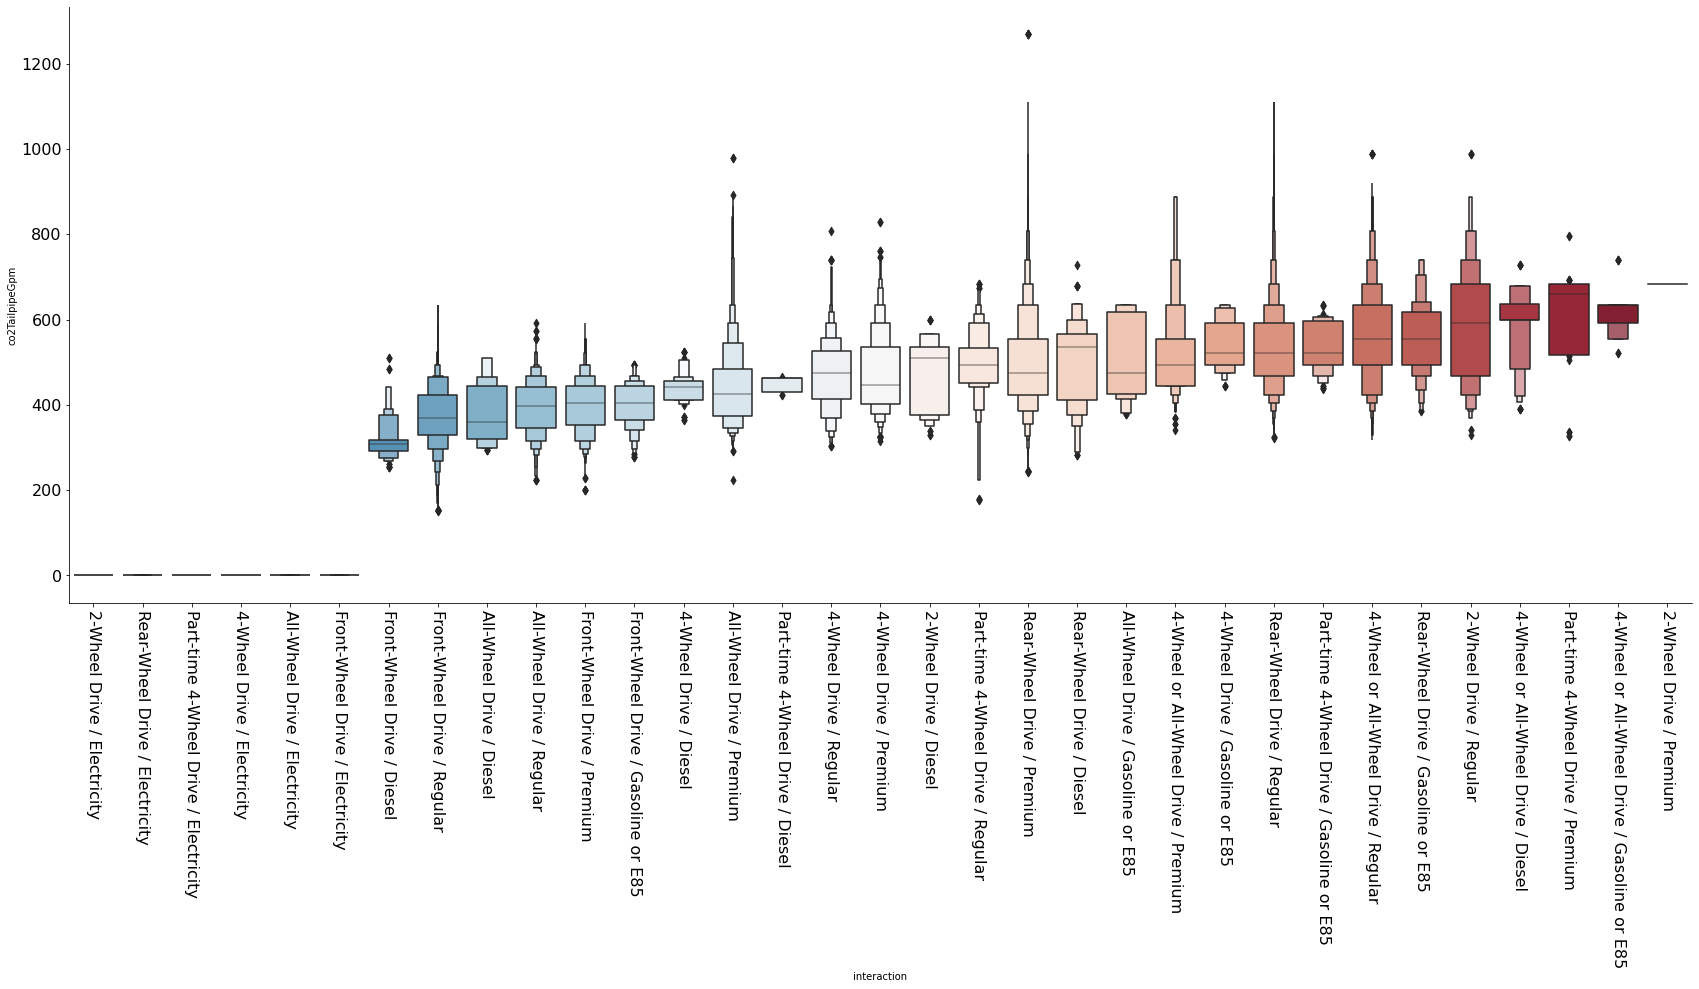

In [37]:
sns.catplot( data=simple_mpg,kind='boxen', x='interaction', y='co2TailpipeGpm',
            order=means_order['interaction'],
            palette='RdBu_r',
             height = 9, aspect=24/9)
plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

#### 2.1.3 Outcome of inital inspection.
Since not all fuel and drive train combinations exist, we now only have 57 combinations to investigate. This is a signifficant reduction of the number of combinations to check, but what are those combinations.

We will see that by applying some logical conditions to the outcome of the Tukey we will gain a signifficant insight into the how these combinations work to explain the varaience in the emissions data.

One part of the logic that we will be investigating is how many of the interactions are statistically similar. Examining the boxen plot above shows that there are large regions of similar vechicles (ie all the elctric types), but it is not uniformly flat across all the data. How many groups of similar means exist?  

## 2.2 Run the Tukey Test

The Tukey test only accepts a single catagorical column. So use the interaction column to find all the mean simialr pairs

#### 2.2.1 Example: Running the Tukey test on the interaction terms

In [ ]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = sm.stats.multicomp.pairwise_tukeyhsd(endog=simple_mpg['co2TailpipeGpm'], groups=simple_mpg['interaction'], alpha=0.05)

# coerce the tukeyhsd table to a DataFrame
tukey_results = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

# inspect the results of the Tukey test
tukey_results

,group1,group2,meandiff,p-adj,lower,upper,reject
0,2-Wheel Drive / Diesel,2-Wheel Drive / Electricity,-474.6458,0.001,-583.0972,-366.1944,True
1,2-Wheel Drive / Diesel,2-Wheel Drive / Premium,208.9696,0.900,-164.8925,582.8317,False
2,2-Wheel Drive / Diesel,2-Wheel Drive / Regular,105.8774,0.001,58.5178,153.2370,True
3,2-Wheel Drive / Diesel,4-Wheel Drive / Diesel,-34.8987,0.900,-94.0533,24.2560,False
4,2-Wheel Drive / Diesel,4-Wheel Drive / Electricity,-474.6458,0.001,-665.3792,-283.9124,True
...,...,...,...,...,...,...,...
1591,Rear-Wheel Drive / Premium,Rear-Wheel Drive / Regular,41.6638,0.001,35.2269,48.1006,True
1592,Rear-Wheel Drive / Premium,Rear-Wheel Drive / hybrid Premium,-346.2223,0.001,-403.0485,-289.3961,True
1593,Rear-Wheel Drive / Premium or E85,Rear-Wheel Drive / Regular,98.1350,0.001,41.9980,154.2720,True
1594,Rear-Wheel Drive / Premium or E85,Rear-Wheel Drive / hybrid Premium,-289.7511,0.001,-369.3698,-210.1323,True


In [ ]:
tukey_results.to_hdf(results_path+'idsp_wk5_tukey_results', key='tukey_results', mode='w', format='table')


#### 2.2.2 Inspecting the Tukey results.

Examinign the table above is not particually insightful in the first instance, especially as there are 1596 pairs listed. That said in this isnstance we are looking for only the pairs which are statistically similar.

#### 2.2.3 Example: using ```.loc()``` to idenify all simialr pairs.

In [20]:
tukey_results.loc[tukey_results.reject == False]

,group1,group2,meandiff,p-adj,lower,upper,reject
14,Diesel / 1975-1985,Premium / 2015-2025,-1.0028,0.2314,-2.1844,0.1788,False
18,Diesel / 1975-1985,Regular / 2005-2015,-0.7408,0.7536,-1.9135,0.4319,False
28,Diesel / 1985-1995,Gasoline or E85 / 2015-2025,0.6200,0.9000,-0.8785,2.1185,False
29,Diesel / 1985-1995,Premium / 1975-1985,0.4712,0.9000,-1.6174,2.5599,False
31,Diesel / 1985-1995,Premium / 1995-2005,-0.4770,0.9000,-1.5113,0.5573,False
32,Diesel / 1985-1995,Premium / 2005-2015,0.9808,0.0682,-0.0267,1.9884,False
34,Diesel / 1985-1995,Regular / 1975-1985,-0.9563,0.1312,-2.0072,0.0945,False
35,Diesel / 1985-1995,Regular / 1985-1995,0.1399,0.9000,-0.8496,1.1294,False
36,Diesel / 1985-1995,Regular / 1995-2005,0.3986,0.9000,-0.6001,1.3972,False
39,Diesel / 1995-2005,Diesel / 2005-2015,-1.2417,0.9000,-3.6306,1.1471,False


## 2.3 Finding groups in the similar pairs

What should be observable in the 502 rows above, is that we can see groups of pairs forming. But some vechicles appear in both the **group 1** and the **group 2** columns. Let's see if we can at least find how many times each interaction is similar to another interaction.

#### 2.3.1 Example: Code for filtering and finding the total rejections for each class 



In [ ]:
group1_comp =tukey_results.loc[tukey_results.reject == False].groupby('group1').reject.count()
group2_comp = tukey_results.loc[tukey_results.reject == False].groupby('group2').reject.count()
tukey_accept_h0 = pd.concat([group1_comp, group2_comp], axis=1)

tukey_accept_h0 = tukey_accept_h0.fillna(0)
tukey_accept_h0.columns = ['acceptH0_1', 'acceptH0_2']
tukey_accept_h0['total_sum'] = tukey_accept_h0.acceptH0_1 + tukey_accept_h0.acceptH0_2

# just show the top 20 results
tukey_accept_h0.sort_values('total_sum',ascending=False).head(60)

,acceptH0_1,acceptH0_2,total_sum
4-Wheel or All-Wheel Drive / Premium or E85,34.0,17.0,51.0
Front-Wheel Drive / Midgrade,17.0,29.0,46.0
2-Wheel Drive / Premium,40.0,1.0,41.0
Part-time 4-Wheel Drive / Diesel,10.0,24.0,34.0
Front-Wheel Drive / Gasoline or natural gas,11.0,21.0,32.0
All-Wheel Drive / Midgrade,16.0,15.0,31.0
4-Wheel Drive / Midgrade,24.0,4.0,28.0
4-Wheel or All-Wheel Drive / Gasoline or propane,19.0,8.0,27.0
Rear-Wheel Drive / Gasoline or propane,3.0,24.0,27.0
Rear-Wheel Drive / CNG,6.0,19.0,25.0


#### 2.3.2 Example: Plot the total occurances of each interaction in the Tukey Results

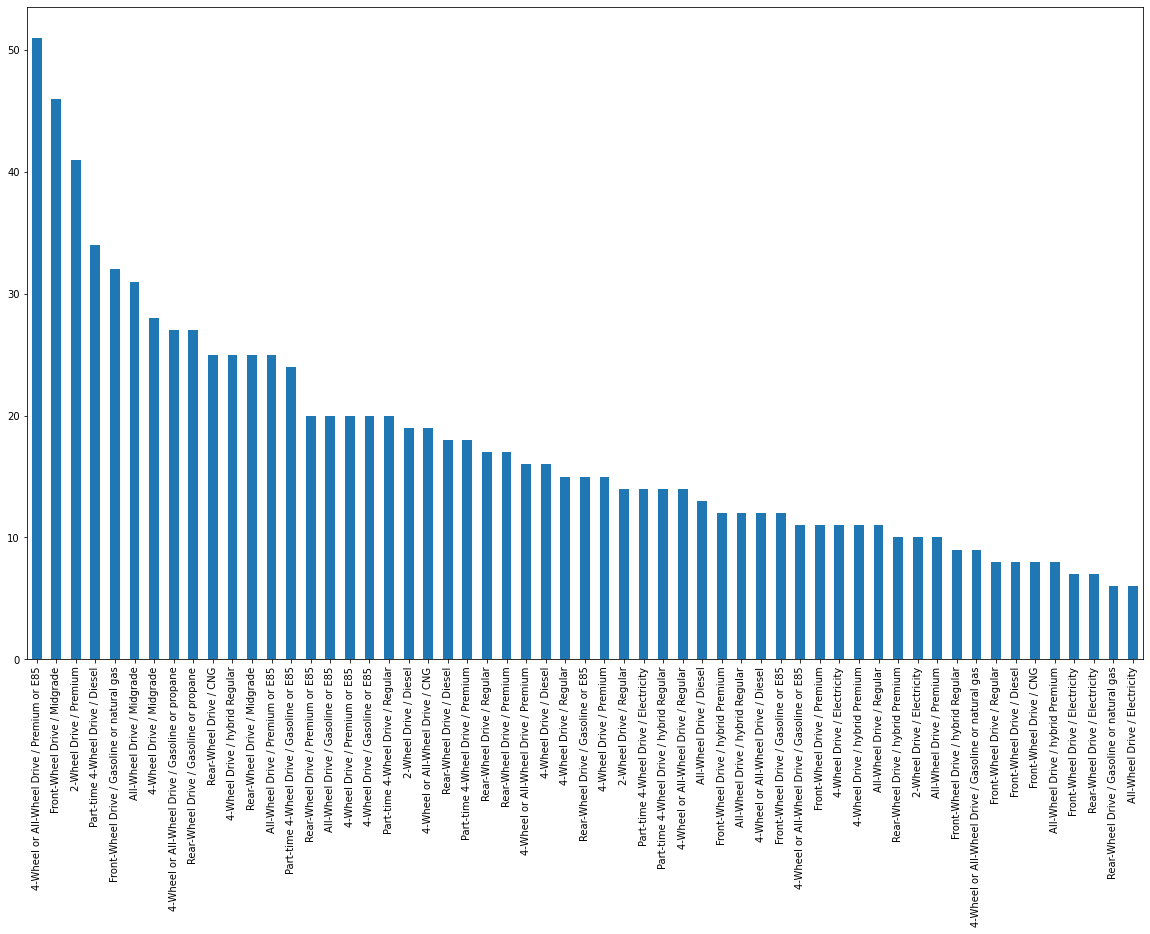

In [ ]:
plt.figure(figsize=(20,12))

tukey_accept_h0['total_sum'].sort_values(ascending=False).plot(kind='bar')

#### 2.3.3 Outcomes of Tukey

 

1.   From the bar plot above, we can observe that for every combination of fuel type and drive train there is at least 5 other fuel-drive combinations which produce statistically similar 
2.   Since we know from our QQ-plot that the model is poor at explaining all the vaiability in the data, this works as anthor confirmation of that fact. Since these interaction terms have such large overlaps, many of the groups form sub-populations, and that these catagories do not fully describe variability in the data.
3.   We have not yet identified how many similarity groups exist. That is a futher computation that we will address in a following lecture.

 



## 2.4 Actions for Tukey HSD analysis

building on from the Actions at the end 5.1, contue your analysis of the subset of the fuel economy data.

#### 2.4.1 Action Use ```.crosstab()``` and the ```.groupby()```functions to understand how many non-zero enteries are in your data set.

This is most likly on the interaction term of your ANOVA results, but if not, state on the focurm that the interaction was not significant, but then conduct the Tukey for your most statistically signifficant dataset.

In [8]:
# load dataset
simple_mpg_select=pd.read_excel(results_path + 'simple_mpg_select.xlsx')

simple_mpg_select.dtypes

year                int64
make               object
model              object
VClass             object
trany              object
drive              object
eng_dscr           object
cylinders         float64
displ             float64
fuelType           object
city08              int64
UCity             float64
highway08           int64
UHighway          float64
co2TailpipeGpm    float64
average_mpg08     float64
displ_cat          object
year_cat           object
dtype: object

The only zeroes are for electricity and gasoline/E85 in the earlier years. 

In [9]:
pd.crosstab(simple_mpg_select['fuelType'],simple_mpg_select['year_cat'])

year_cat,1975-1985,1985-1995,1995-2005,2005-2015,2015-2025
fuelType,,,,,
Diesel,263,367,102,149,194
Electricity,0,0,15,60,286
Gasoline or E85,0,0,171,935,265
Premium,101,1571,2692,4687,4194
Regular,2123,9172,6191,5631,3801


In [10]:
select_groups=(simple_mpg_select.groupby(['fuelType','year_cat'], observed = True)
                            .average_mpg08
                            .agg(count ='count', mean ='mean', median = 'median', standerd_dev='std', skew ='skew' )
                            .reset_index()
                            .copy())

In [11]:
# 0-0 groupings are ignored
select_groups

,fuelType,year_cat,count,mean,median,standerd_dev,skew
0,Diesel,1975-1985,263,23.425856,22.00,5.594880,0.945776
1,Diesel,1985-1995,367,19.895095,18.00,4.975270,2.090054
2,Diesel,1995-2005,102,30.745098,34.50,8.973212,-0.869320
3,Diesel,2005-2015,149,29.503356,32.50,5.580037,-0.550435
4,Diesel,2015-2025,194,27.015464,25.00,4.893399,1.167655
5,Electricity,1995-2005,15,53.900000,55.50,16.441672,0.060377
6,Electricity,2005-2015,60,98.058333,101.00,17.119246,-0.613675
7,Electricity,2015-2025,286,101.737762,103.75,17.127933,-0.161479
8,Gasoline or E85,1995-2005,171,17.438596,16.50,2.821248,0.399152
9,Gasoline or E85,2005-2015,935,18.332620,17.00,4.011901,1.045970


In [12]:
num_groups = len(select_groups)

non_zero_pairs= sci.special.comb(num_groups, 2) 

print('the number of possiable pairs are {}, for a total of {} combinations'.format(num_groups,non_zero_pairs))

the number of possiable pairs are 21, for a total of 210.0 combinations


#### 2.4.2  Action Run the Tukey HSD test to identify which how the data is grouping, and if it can be said how effective the catagorical variables are at describing the dataset.

In [13]:
simple_mpg_select['interaction'] = simple_mpg_select.fuelType.astype(str) + " / " + simple_mpg_select.year_cat.astype(str)

In [14]:
interaction_groups=mpg_groups=(simple_mpg_select.groupby(['interaction'], observed = True)
                            .average_mpg08
                            .agg(count ='count', mean ='mean', median = 'median', standerd_dev='std', skew ='skew' )
                            .reset_index()
                            .copy())

means_order=(interaction_groups.sort_values('mean',ascending=True))
                                  
median_order =interaction_groups.sort_values('median',ascending=True)

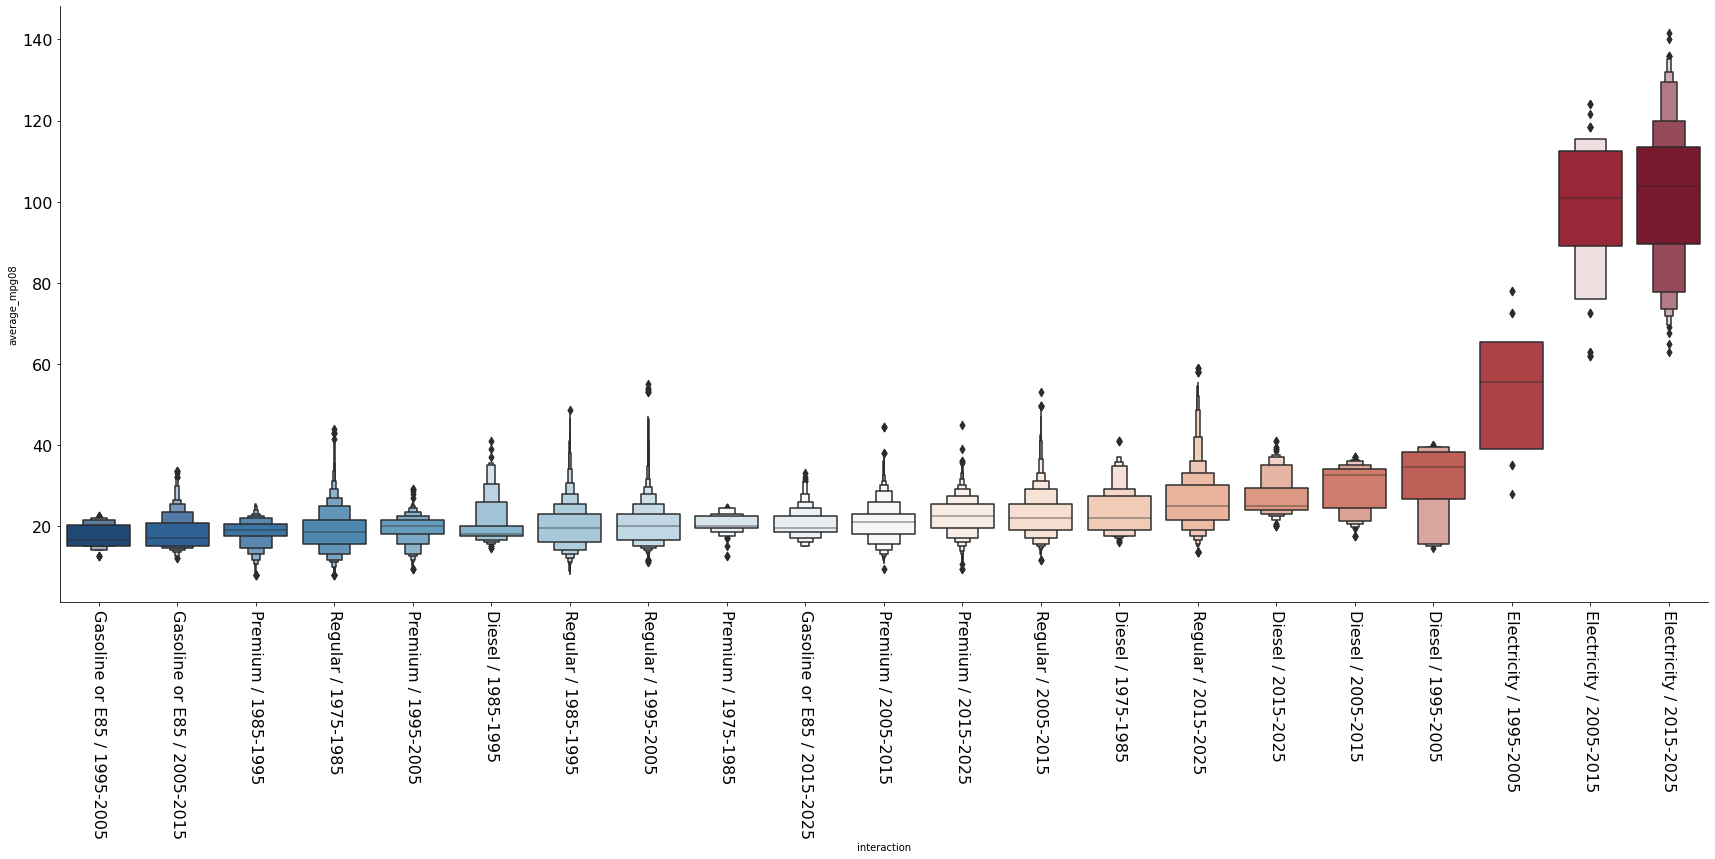

In [21]:
sns.catplot(data=simple_mpg_select,kind='boxen', x='interaction', y='average_mpg08',
            order=means_order['interaction'],
            palette='RdBu_r',
             height = 9, aspect=24/9)
plt.xticks(rotation=-90)
plt.tick_params(labelsize=16)

In [16]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = sm.stats.multicomp.pairwise_tukeyhsd(endog=simple_mpg_select['average_mpg08'], groups=simple_mpg_select['interaction'], alpha=0.05)

# coerce the tukeyhsd table to a DataFrame
tukey_results = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

# inspect the results of the Tukey test
tukey_results

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Diesel / 1975-1985,Diesel / 1985-1995,-3.5308,0.001,-5.0325,-2.0290,True
1,Diesel / 1975-1985,Diesel / 1995-2005,7.3192,0.001,5.1510,9.4875,True
2,Diesel / 1975-1985,Diesel / 2005-2015,6.0775,0.001,4.1715,7.9835,True
3,Diesel / 1975-1985,Diesel / 2015-2025,3.5896,0.001,1.8304,5.3488,True
4,Diesel / 1975-1985,Electricity / 1995-2005,30.4741,0.001,25.5397,35.4086,True
...,...,...,...,...,...,...,...
205,Regular / 1985-1995,Regular / 2005-2015,2.6500,0.001,2.3354,2.9647,True
206,Regular / 1985-1995,Regular / 2015-2025,6.0087,0.001,5.6501,6.3673,True
207,Regular / 1995-2005,Regular / 2005-2015,2.3914,0.001,2.0491,2.7337,True
208,Regular / 1995-2005,Regular / 2015-2025,5.7500,0.001,5.3670,6.1331,True


In [19]:
# identify similar pairs
tukey_results.loc[tukey_results.reject == False]

,group1,group2,meandiff,p-adj,lower,upper,reject
14,Diesel / 1975-1985,Premium / 2015-2025,-1.0028,0.2314,-2.1844,0.1788,False
18,Diesel / 1975-1985,Regular / 2005-2015,-0.7408,0.7536,-1.9135,0.4319,False
28,Diesel / 1985-1995,Gasoline or E85 / 2015-2025,0.6200,0.9000,-0.8785,2.1185,False
29,Diesel / 1985-1995,Premium / 1975-1985,0.4712,0.9000,-1.6174,2.5599,False
31,Diesel / 1985-1995,Premium / 1995-2005,-0.4770,0.9000,-1.5113,0.5573,False
32,Diesel / 1985-1995,Premium / 2005-2015,0.9808,0.0682,-0.0267,1.9884,False
34,Diesel / 1985-1995,Regular / 1975-1985,-0.9563,0.1312,-2.0072,0.0945,False
35,Diesel / 1985-1995,Regular / 1985-1995,0.1399,0.9000,-0.8496,1.1294,False
36,Diesel / 1985-1995,Regular / 1995-2005,0.3986,0.9000,-0.6001,1.3972,False
39,Diesel / 1995-2005,Diesel / 2005-2015,-1.2417,0.9000,-3.6306,1.1471,False


In [25]:
group1_comp =tukey_results.loc[tukey_results.reject == False].groupby('group1').reject.count()
group2_comp = tukey_results.loc[tukey_results.reject == False].groupby('group2').reject.count()
tukey_accept_h0 = pd.concat([group1_comp, group2_comp], axis=1)

tukey_accept_h0 = tukey_accept_h0.fillna(0)
tukey_accept_h0.columns = ['acceptH0_1', 'acceptH0_2']
tukey_accept_h0['total_sum'] = tukey_accept_h0.acceptH0_1 + tukey_accept_h0.acceptH0_2

# maxmimum number of groups was 21
tukey_accept_h0.sort_values('total_sum',ascending=False).head(21)

,acceptH0_1,acceptH0_2,total_sum
Premium / 1975-1985,6.0,2.0,8.0
Diesel / 1985-1995,7.0,0.0,7.0
Gasoline or E85 / 2015-2025,5.0,1.0,6.0
Regular / 1975-1985,0.0,5.0,5.0
Premium / 1995-2005,1.0,3.0,4.0
Regular / 1985-1995,1.0,3.0,4.0
Regular / 1995-2005,0.0,4.0,4.0
Premium / 1985-1995,1.0,3.0,4.0
Gasoline or E85 / 2005-2015,2.0,1.0,3.0
Premium / 2005-2015,0.0,3.0,3.0


2.4.3 Action: Produce the pair similary plot like in 2.3.2 and share all your analysis in the [Moddle Forum](https://moodle.gla.ac.uk/mod/forum/view.php?id=2877349) on the thread which you have created.

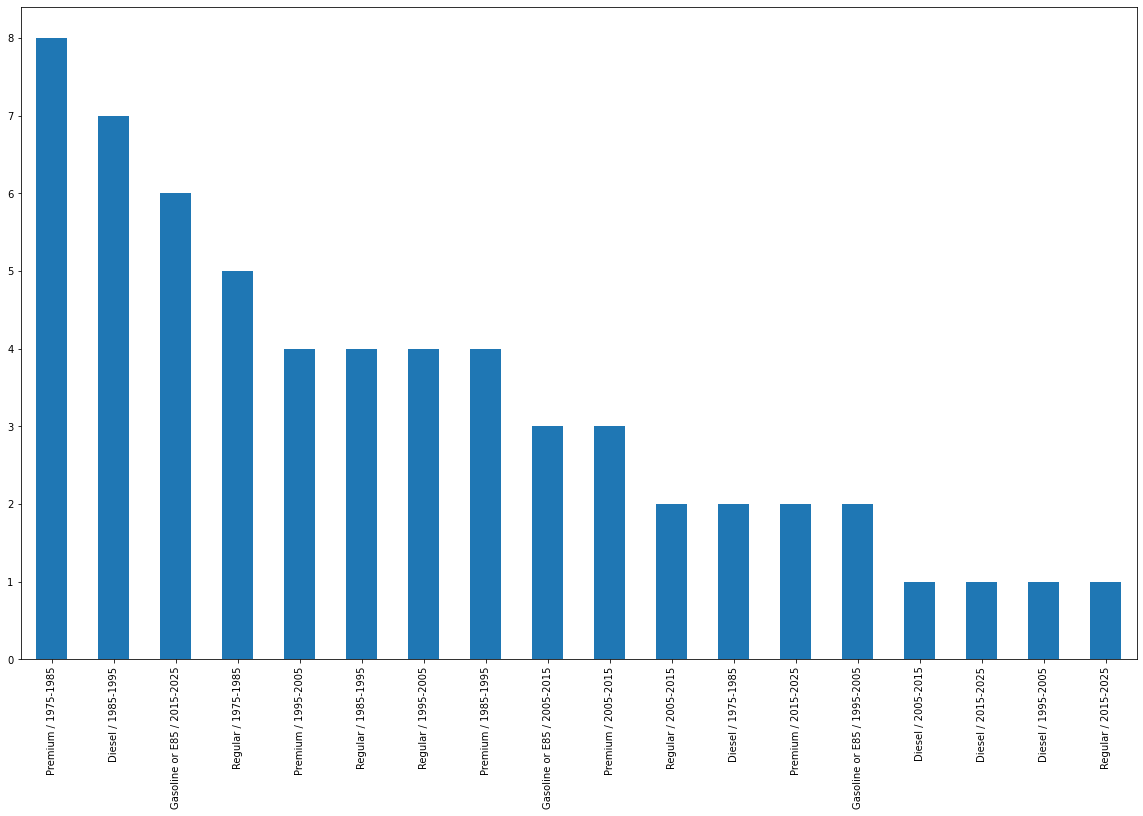

In [26]:
plt.figure(figsize=(20,12))

tukey_accept_h0['total_sum'].sort_values(ascending=False).plot(kind='bar')